# Counterfactual Generative Networks (CGN) on Colored MNIST

### Overview:
This notebook implements the **Counterfactual Generative Networks (CGN)** from the ICLR 2021 paper on a simplified dataset: **Colored MNIST**. The goal is to generate images that separate **shape**, **foreground texture**, and **background texture** into **independent causal factors**.


### Main Objectives:
- Train a **Generative Adversarial Network (GAN)** where:
  - The **Generator (CGN)** learns to produce realistic colored digits by independently generating:
    - A **mask** (shape of the digit),
    - A **foreground** (digit color),
    - A **background** (background color).
  - The **Discriminator** tries to distinguish real colored MNIST digits from fake ones.

- Encourage the model to:
  - Learn **clear shapes** (Binary Mask Loss),
  - Make images look **realistic** (Perceptual Loss using VGG16),
  - Fool the Discriminator (Adversarial Loss).


### Key Features:
- **Colored MNIST Dataset**:
  - A modified MNIST where each digit has **random foreground and background colors**.
- **Mask + Texture Generation**:
  - The Generator outputs masks, foreground, and background textures.
- **Counterfactual Sampling**:
  - Generates new images by mixing masks and textures from different classes.


### Training Process:
1. **Generator** tries to fool the Discriminator with:
   - Adversarial Loss.
   - Binary Mask Loss for clear digit shapes.
   - Perceptual Loss for realistic appearance.

2. **Discriminator** tries to detect real vs. fake digits.

3. Training losses are tracked and visualized:
   - Generator Loss.
   - Discriminator Loss.


### Outputs:
- Generated sample images saved during training.
- Loss curves showing training progress.
- Visual demonstration of CGN’s ability to disentangle shape and texture.


### Goal:
Demonstrate **causal disentanglement** by training CGN on Colored MNIST, showcasing how the model can **separately control** shape and texture, and produce **counterfactual examples**.

## install dependencies

In [1]:
!pip install torch torchvision yacs tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## imports & config

1. Install & import everything you need.
2. Define a single “cfg” object for all hyperparameters.
3. Detect whether to run on GPU or CPU.

In [2]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from PIL import Image, ImageColor
from yacs.config import CfgNode as CN
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
def get_cfg_defaults():
    cfg = CN()
    # model / training hyperparams
    cfg.TRAIN = CN()
    cfg.TRAIN.BATCH_SIZE = 64
    cfg.TRAIN.EPOCHS     = 20
    cfg.TRAIN.WORKERS    = 4
    cfg.TRAIN.LR         = 2e-4
    cfg.TRAIN.BETAS      = (0.5,0.999)
    cfg.TRAIN.SAVE_ITER  = 500
    cfg.MODEL = CN()
    cfg.MODEL.N_CLASSES = 10
    cfg.MODEL.LATENT_SZ = 12
    cfg.MODEL.NGF      = 32
    cfg.MODEL.NDF      = 32
    return cfg.clone()

cfg = get_cfg_defaults()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:",device)

Using device: cuda


## Colored‑MNIST dataloader
It creates a custom dataset called ColoredMNIST, where each grayscale digit in MNIST is recolored with a foreground (digit color) and background (canvas color). Then it returns PyTorch DataLoaders so we can feed batches to our model.

In [4]:
class ColoredMNIST(Dataset):
    def __init__(self, train=True, color_var=0.02):
        raw = datasets.MNIST('data', train=True, download=True)
        data = raw.data[:60000] if train else raw.data[60000:]
        labels = raw.targets[:60000] if train else raw.targets[60000:]
        self.labels = labels
        # stack grayscale→3 channels float
        self.ims = torch.stack([data,data,data],dim=1).float()/255.
        # ten base colors
        palette = ['darkgreen','darkblue','#b03060','orangered','yellow',
                   'burlywood','lime','aqua','fuchsia','#6495ed']
        self.colors = [torch.tensor(ImageColor.getcolor(c,"RGB"))/255. for c in palette]
        self.T = transforms.Compose([
            transforms.Resize((32,32), Image.NEAREST),
            transforms.Normalize((0.5,)*3,(0.5,)*3)
        ])

    def __len__(self): return len(self.labels)
    def __getitem__(self, i):
        c = int(self.labels[i])
        fg = self.colors[c] + torch.randn(3)*0.01
        bg = self.colors[(c+3)%10] + torch.randn(3)*0.01
        mask = (self.ims[i]>0.1).float()
        img = mask*fg.view(3,1,1) + (1-mask)*bg.view(3,1,1)
        img = self.T(img)
        return {'ims':img, 'labels':self.labels[i]}

def get_dataloaders(cfg):
    ds_tr = ColoredMNIST(train=True)
    ds_te = ColoredMNIST(train=False)
    dl_tr = DataLoader(ds_tr, batch_size=cfg.TRAIN.BATCH_SIZE,
                       shuffle=True, num_workers=cfg.TRAIN.WORKERS)
    dl_te = DataLoader(ds_te, batch_size=cfg.TRAIN.BATCH_SIZE*2,
                       shuffle=False, num_workers=cfg.TRAIN.WORKERS)
    return dl_tr, dl_te

dl_train, dl_test = get_dataloaders(cfg)
print("Train / test size:", len(dl_train.dataset), len(dl_test.dataset))

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.77MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.18MB/s]


Train / test size: 60000 0


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## CGN & Discriminator
1. CGN = Creates fake images by mixing shape + textures.
2. DiscLin = Judges if images are real or fake.
3. init_weights = Helps the models start with good weights.
4. Patch2Image + RandomCrop = Add variety to textures, so images aren’t too perfect.

In [5]:
# simple weight init
def init_weights(m):
    if hasattr(m,'weight') and isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.orthogonal_(m.weight, 0.1)
        if m.bias is not None: nn.init.constant_(m.bias,0)

class Reshape(nn.Module):
    def __init__(self,*shape): super().__init__(); self.shape=shape
    def forward(self,x): return x.view(self.shape)

class Patch2Image(nn.Module):
    def __init__(self, img_sz, n_up):
        super().__init__()
        self.img_sz = img_sz
        self.n_up = n_up

    def forward(self,x):
        x = x.repeat(1,1,self.n_up,1).repeat(1,1,1,self.n_up)
        return x

class RandomCrop(nn.Module):
    def __init__(self, sz): super().__init__(); self.sz=sz
    def forward(self,x):
        h,w = x.shape[-2:]
        i = torch.randint(0,h-self.sz,(1,)).item()
        j = torch.randint(0,w-self.sz,(1,)).item()
        return x[...,i:i+self.sz,j:j+self.sz]

class CGN(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.latent = cfg.MODEL.LATENT_SZ
        # embedding + gan dims
        self.emb = nn.Embedding(cfg.MODEL.N_CLASSES, cfg.MODEL.N_CLASSES)
        init_sz = 32//4
        inp = self.latent + cfg.MODEL.N_CLASSES
        ngf = cfg.MODEL.NGF

        def up(cin,cout):
            return [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(cin,cout,3,padding=1,bias=False),
                nn.BatchNorm2d(cout),
                nn.LeakyReLU(0.2,inplace=True)
            ]

        # shape net → mask
        self.f_shape = nn.Sequential(
            nn.Linear(inp, ngf*2*init_sz*init_sz),
            Reshape(-1,ngf*2,init_sz,init_sz),
            *up(ngf*2,ngf), *up(ngf,1)
        )
        # two texture nets
        self.f_tex1 = nn.Sequential(
            nn.Linear(inp, ngf*2*init_sz*init_sz),
            Reshape(-1,ngf*2,init_sz,init_sz),
            *up(ngf*2,ngf*2), *up(ngf*2,3), nn.Tanh()
        )
        self.f_tex2 = nn.Sequential(
            nn.Linear(inp, ngf*2*init_sz*init_sz),
            Reshape(-1,ngf*2,init_sz,init_sz),
            *up(ngf*2,ngf*2), *up(ngf*2,3), nn.Tanh()
        )
        self.shuff = nn.Sequential(Patch2Image(32,2), RandomCrop(32))
        self.apply(init_weights)

    def get_inp(self,y):
        u = torch.randn(len(y), self.latent, device=y.device)
        v = self.emb(y)
        return torch.cat([u,v],1)

    def forward(self, y, cf=False):
        if cf:
            y1 = y[torch.randperm(len(y))]
            y2 = y[torch.randperm(len(y))]
            i0,i1,i2 = self.get_inp(y), self.get_inp(y1), self.get_inp(y2)
        else:
            i0 = i1 = i2 = self.get_inp(y)
        m = self.f_shape(i0).clamp(1e-4,0.9999).repeat(1,3,1,1)
        f = self.shuff(self.f_tex1(i1))
        b = self.shuff(self.f_tex2(i2))
        return m,f,b

class DiscLin(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.emb = nn.Embedding(cfg.MODEL.N_CLASSES, cfg.MODEL.N_CLASSES)
        self.net = nn.Sequential(
            nn.Linear(cfg.MODEL.N_CLASSES+3*32*32, cfg.MODEL.NDF),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(cfg.MODEL.NDF,1)
        )
    def forward(self,x,y):
        v = torch.cat([x.view(len(x),-1), self.emb(y)],1)
        return self.net(v).squeeze()

## losses & optimizer helper

1. BinaryLoss → Pushes the mask to be close to 0 or 1 (clean shapes).
2. PerceptualLoss → Ensures fake images look like real ones, using VGG features.
3. Opts / Optimizers → Helps manage and update multiple optimizers easily.



In [6]:
class BinaryLoss(nn.Module):
    def __init__(self,w): super().__init__(); self.w=w
    def forward(self,m):
        return self.w * (-(m*torch.log2(m)+(1-m)*torch.log2(1-m))).mean()

class PerceptualLoss(nn.Module):
    def __init__(self, w_style):
        super().__init__()
        vgg = torch.hub.load('pytorch/vision','vgg16',pretrained=True).features.eval()
        for p in vgg.parameters(): p.requires_grad=False
        pools = [i for i,l in enumerate(vgg) if isinstance(l,nn.MaxPool2d)]
        self.m = vgg; self.layers = pools[:3]; self.w = w_style
    def forward(self, x,y):
        def feats(z):
            out=[]; h=z
            for i,l in enumerate(self.m):
                h=l(h)
                if i in self.layers: out.append(h)
            return out
        fx,fy = feats(x), feats(y)
        loss = 0
        for a,b in zip(fx,fy):
            loss += F.l1_loss(a,b)
        return loss

class Opts:
    def __init__(self): self.o={}
    def set(self,k,m,lr,betas): self.o[k]=torch.optim.Adam(m.parameters(),lr,betas=betas)
    def step(self,keys):
        for k in keys: self.o[k].step(); self.o[k].zero_grad()

# — utils/train_utils.py —
class Optimizers():
    def __init__(self):
        self._modules = {}
    def set(self, k, model, lr=3e-3, betas=(0.9,0.999)):
        self._modules[k] = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)
    def step(self, k_list=None, zero=True):
        if k_list is None: k_list = self._modules.keys()
        for k in k_list:
            self._modules[k].step()
            if zero: self._modules[k].zero_grad()
    def zero_grad(self, k_list):
        for k in k_list: self._modules[k].zero_grad()

## training loop
### Inside Each Training Step:

#### **Generator (G)** tries to make **fake images**:
- **Goal**: Fool the **Discriminator** into thinking fake images are **real**.
- **Loss (`loss_g`)**:
  - **Adversarial loss** → Did **G** fool **D**?
  - **Binary mask loss** → Is the **mask** clear?
  - **Perceptual loss** → Do **fakes** look like **real MNIST**?


#### **Discriminator (D)** tries to **tell real from fake**:
- **Real Loss**: Can **D** spot the **real** image?
- **Fake Loss**: Can **D** spot the **fake** image?
- **Total**: `loss_d = (real_loss + fake_loss) / 2`


#### **Update Models**:
- Adjust weights of **G** and **D** using the losses.


#### **Save Loss Values**:
- `g_losses.append(loss_g.item())` → Save **G's** loss.
- `d_losses.append(loss_d.item())` → Save **D's** loss.


#### **Show Progress**:
- Every **50 steps**, it shows you the current **losses**.
- Every **SAVE_ITER steps**, it saves **sample images**.


In [7]:
# ─── LOSS TRACKING ─────────────────────────────────────────────────────────────

g_losses = []
d_losses = []
step = 0  # if you’re already using step, just keep using it
# Additional tracking
mask_means = []
mask_vars = []

# ────────────────────────────────────────────────────────────────────────────────


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# models → GPU
cgn  = CGN(cfg).to(device)
disc = DiscLin(cfg).to(device)

# losses → GPU
L_adv = nn.MSELoss().to(device)
L_bin = BinaryLoss(0.5).to(device)
L_per = PerceptualLoss([0.05,0.05,0.05]).to(device)

# optimizers
opts = Optimizers()
opts.set('G', cgn,  cfg.TRAIN.LR, cfg.TRAIN.BETAS)
opts.set('D', disc, cfg.TRAIN.LR, cfg.TRAIN.BETAS)

root = Path('samples'); root.mkdir(exist_ok=True)
step = 0

for epoch in range(cfg.TRAIN.EPOCHS):
    pbar = tqdm(dl_train, desc=f"Epoch {epoch}")
    for batch in pbar:
        x_real = batch['ims'].to(device)
        y_real = batch['labels'].to(device)

        # —– train G
        opts.zero_grad(['G'])
        y_noise = torch.randint(0, cfg.MODEL.N_CLASSES, (len(y_real),), device=device)
        m,f,b = cgn(y_noise)
        x_fake = m*f + (1-m)*b

        loss_g = L_adv(disc(x_fake, y_noise),
                       torch.ones_like(y_real, dtype=torch.float, device=device))
        loss_g = loss_g + L_bin(m) + L_per(x_fake, x_real)
        loss_g.backward()
        opts.step(['G'])

        # —– train D
        opts.zero_grad(['D'])
        real_loss = L_adv(disc(x_real, y_real),
                          torch.ones_like(y_real, dtype=torch.float, device=device))
        fake_loss = L_adv(disc(x_fake.detach(), y_noise),
                          torch.zeros_like(y_real, dtype=torch.float, device=device))
        loss_d = 0.5*(real_loss + fake_loss)
        loss_d.backward()
        opts.step(['D'])

        # logging & sampling
        if step % 50 == 0:
            pbar.set_postfix(Lg=loss_g.item(), Ld=loss_d.item())
        if step % cfg.TRAIN.SAVE_ITER == 0:
            grid = make_grid(x_fake[:16], nrow=4, normalize=True).cpu()
            save_image(grid, root/f"step_{step:05d}.png")

        # Track mask statistics
        mean_mask = m.mean().item()
        var_mask = m.var().item()

        mask_means.append(mean_mask)
        mask_vars.append(var_mask)

        # record for plotting
        g_losses.append(loss_g.item())
        d_losses.append(loss_d.item())

        step += 1

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 152MB/s]
Epoch 19: 100%|██████████| 938/938 [00:38<00:00, 24.34it/s, Ld=0.0362, Lg=7.9]


## visualize final samples

### Explanation of Generated Output

These image grids display **generated samples** from the **Counterfactual Generative Network (CGN)** trained on **Colored MNIST**.


#### What Each Grid Shows:
- Each square shows a **synthetic MNIST digit** created by the model.
- Digits are rendered with:
  - **Foreground colors** for the digit itself.
  - **Background colors** for the surrounding space.
- Colors are **randomized** to test **causal relationships**.


#### Purpose of the Output:
- Visualize how well the **Generator (CGN)** creates **realistic digit images**.
- Demonstrate the CGN's ability to **separate**:
  - **Shape** (digit identity, like 2, 5, 7).
  - **Texture/Color** (background & foreground).
- Show the model's ability to **mix and match** shapes with different textures.


#### How to Interpret:
- **Clear digits** with **varied colors** = good model performance.
- **Blurry or messy digits** = model might need:
  - More training.
  - Better hyperparameter tuning.


#### Why This Matters:
- Helps track **visual progress** of training.
- Allows **comparison** of generated samples over time.


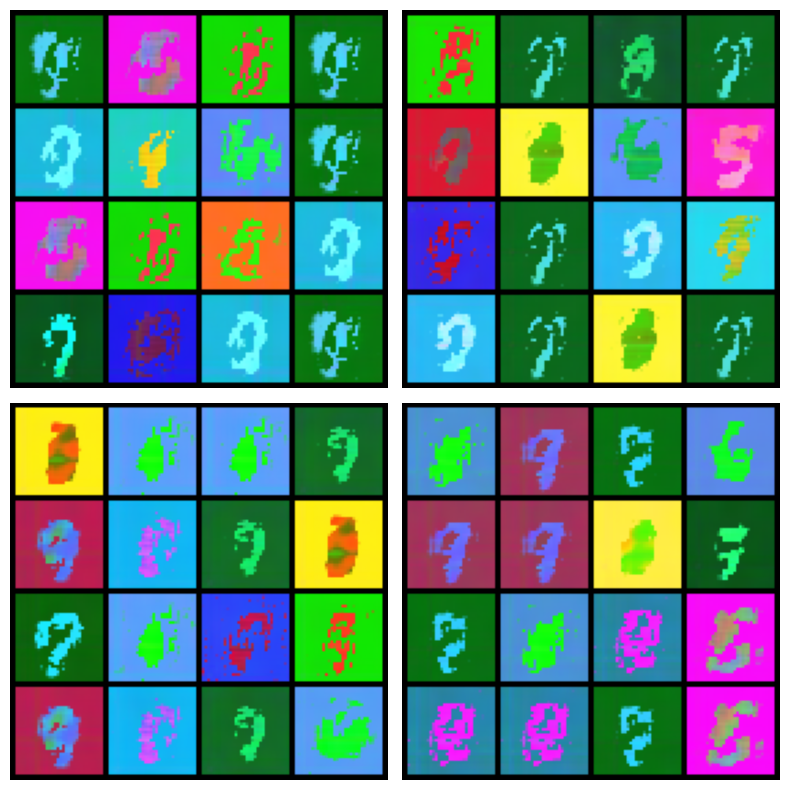

In [8]:
from IPython.display import Image, display
imgs = sorted(root.glob("step_*.png"))[-4:]
plt.figure(figsize=(8,8))
for i,p in enumerate(imgs):
    plt.subplot(2,2,i+1)
    plt.imshow(plt.imread(p))
    plt.axis('off')
plt.tight_layout()

## Plot Training Losses
### Training Loss Chart Summary

This chart shows how the **Generator** and **Discriminator** losses change during training.


#### **Blue Line: Generator Loss**
- The Generator creates fake images to fool the Discriminator.
- **Higher Loss**: The Generator is struggling.
- **Lower Loss**: The Generator is improving.
- In the chart:
  - Starts high, then stabilizes around **7-8**.
  - A spike at the start is **normal**.


#### **Orange Line: Discriminator Loss**
- The Discriminator detects real vs. fake images.
- **Higher Loss**: It’s being fooled.
- **Lower Loss**: It’s doing well.
- In the chart:
  - Stays low around **0.1**, meaning it is detecting fakes well.


#### **What to Watch For:**
- **Generator Loss too low** → Might be overfitting.
- **Discriminator Loss too high** → It’s getting fooled too much.
- Both losses **don’t need to be equal**, but should stay balanced.


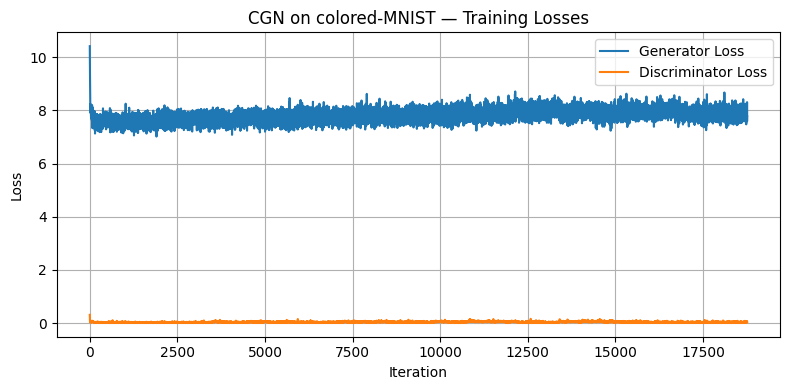

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.title('CGN on colored‑MNIST — Training Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Generated Mask Statistics

This chart shows how the **CGN model** is generating **masks** over time during training. The mask helps separate the **foreground (digit)** from the **background**.


### **Left Chart: Mean of Generated Masks (μmask)**

- **What it shows:**
  - The **average value** of pixels in the masks across training iterations.
  - A good mask should not be all black or all white — it should be in between (showing both foreground & background).
  
- **What it means:**
  - Values between **0.2 and 0.45** indicate masks are not collapsing.
  - **Balanced masks** help the model generate clear digits with distinct textures.


### **Right Chart: Variance of Generated Masks**

- **What it shows:**
  - The **variance** (spread) of pixel values in the masks.
  - Higher variance = more diverse masks, better at separating shapes from background.

- **What it means:**
  - Variance stays around **0.18 to 0.22** → indicates stable mask generation.
  - Low variance would mean the model generates very similar masks, which is bad.


### **Overall Interpretation:**
- The masks are **diverse** and **not collapsed**.
- This is a **healthy sign** for CGN's ability to **disentangle** object shape and texture.

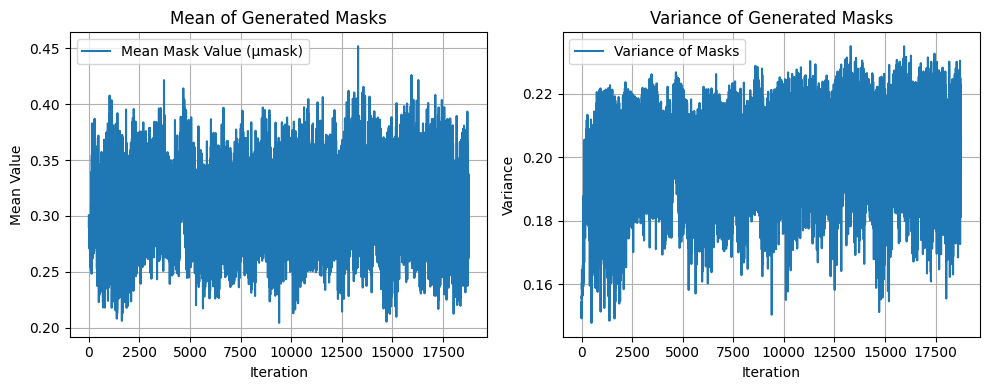

In [10]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(mask_means, label='Mean Mask Value (μmask)')
plt.title('Mean of Generated Masks')
plt.xlabel('Iteration')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(mask_vars, label='Variance of Masks')
plt.title('Variance of Generated Masks')
plt.xlabel('Iteration')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()